# Material Mathematics (Group 5) Data Proposal Preprocessing

# import packages

In [1]:
! pip install keras_tuner

  Using cached keras_tuner-1.1.3-py3-none-any.whl (135 kB)
  Using cached kt_legacy-1.0.4-py3-none-any.whl (9.6 kB)


In [2]:
import numpy as np
from numpy import linalg as LA

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import keras_tuner as kt

import pickle as pkl

## Hypothesis

In this proposal, we plan to find the correlation between each parameter and the solubility. We divide the parameters into two groups, trying to decide which parameter in each group has affected the solubility the most. One has a positive correlation with the molecules’ solubility, and the other one has a negative correlation with the molecules’ solubility.

In the positive correlation group, we guess that Number of H acceptors (`NumHAcceptors`) has the largest weight. Based on our current knowledge, because there is an equivalent partial negative charge on the atom bonded to hydrogen, this atom can accept H-bonds from water. Therefore, it causes the compound’s solubility to be better than compounds without H-bonds. Hydrogen bond strengths range from 4 kJ to 50 kJ per mole of hydrogen bonds. On the contrary, van der Waals interaction is a relatively weak force ranging from 0.5 to 1 kcal/mol.

In the negative correlation group, we hypothesize that the heavy atom count weighted the solubility the most. Since organic compounds are usually composed of C, O, and H, the higher molecular weight and more C make the compound more insoluble in water if H is not considered.

## Data Import and Overview

In this section, we take a cursory look at the given dataset. We aim to understand each column and identify data relevant to our analysis. 

In [3]:
df = pd.read_csv("curated-solubility-dataset.csv")

In [4]:
df.head(10)

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...,SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,0.000000,1,G1,392.510,...,17.0,142.0,0.0,0.0,0.0,0.0,0.00,158.520601,0.000000e+00,210.377334
1,A-4,Benzo[cd]indol-2(1H)-one,InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,0.000000,1,G1,169.183,...,0.0,62.0,2.0,0.0,1.0,3.0,29.10,75.183563,2.582996e+00,511.229248
2,A-5,4-chlorobenzaldehyde,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,0.000000,1,G1,140.569,...,1.0,46.0,1.0,0.0,0.0,1.0,17.07,58.261134,3.009782e+00,202.661065
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...,XTUPUYCJWKHGSW-UHFFFAOYSA-L,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,0.000000,1,G1,756.226,...,10.0,264.0,6.0,0.0,0.0,6.0,120.72,323.755434,2.322963e-07,1964.648666
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,0.000000,1,G1,422.525,...,12.0,164.0,2.0,4.0,4.0,6.0,56.60,183.183268,1.084427e+00,769.899934
5,A-10,vinyltoluene,"InChI=1S/C9H10/c1-3-9-6-4-5-8(2)7-9/h3-7H,1H2,2H3",JZHGRUMIRATHIU-UHFFFAOYSA-N,Cc1cccc(C=C)c1,-3.123150,0.000000,1,G1,118.179,...,1.0,46.0,1.0,0.0,0.0,1.0,0.00,55.836626,3.070761e+00,211.033225
6,A-11,3-(3-ethylcyclopentyl)propanoic acid,InChI=1S/C10H18O2/c1-2-8-3-4-9(7-8)5-6-10(11)1...,WVRFSLWCFASCIS-UHFFFAOYSA-N,CCC1CCC(CCC(O)=O)C1,-3.286116,0.000000,1,G1,170.252,...,4.0,70.0,0.0,1.0,1.0,1.0,37.30,73.973655,2.145839e+00,153.917569
7,A-12,"11,16,17,21-tetrahydroxypregna-1,4-diene-3,20-...",InChI=1S/C21H28O6/c1-19-6-5-12(23)7-11(19)3-4-...,SEKYBDYVXDAYPY-UHFFFAOYSA-N,CC12CC(O)C3C(CCC4=CC(=O)C=CC34C)C1CC(O)C2(O)C(...,-2.664549,0.000000,1,G1,376.449,...,2.0,148.0,0.0,3.0,4.0,4.0,115.06,158.135542,1.776978e+00,755.770792
8,A-14,bis(4-fluorophenyl)methanone,InChI=1S/C13H8F2O/c14-11-5-1-9(2-6-11)13(16)10...,LSQARZALBDFYQZ-UHFFFAOYSA-N,Fc1ccc(cc1)C(=O)c2ccc(F)cc2,-4.396652,0.431513,2,G3,218.202,...,2.0,80.0,2.0,0.0,0.0,2.0,17.07,91.346032,2.315628e+00,452.960733
9,A-15,1-[2-(benzoyloxy)propoxy]propan-2-yl benzoate ...,InChI=1S/C20H22O5/c21-19(17-9-3-1-4-10-17)24-1...,BYQDGAVOOHIJQS-UHFFFAOYSA-N,O=C(OCCCOCCCOC(=O)c1ccccc1)c2ccccc2,-4.595503,0.118551,2,G3,342.391,...,10.0,132.0,2.0,0.0,0.0,2.0,61.83,147.071714,1.447050e+00,582.150793


In [5]:
df.columns

Index(['ID', 'Name', 'InChI', 'InChIKey', 'SMILES', 'Solubility', 'SD',
       'Ocurrences', 'Group', 'MolWt', 'MolLogP', 'MolMR', 'HeavyAtomCount',
       'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds',
       'NumValenceElectrons', 'NumAromaticRings', 'NumSaturatedRings',
       'NumAliphaticRings', 'RingCount', 'TPSA', 'LabuteASA', 'BalabanJ',
       'BertzCT'],
      dtype='object')

In [6]:
df["Group"]

0       G1
1       G1
2       G1
3       G1
4       G1
        ..
9977    G1
9978    G1
9979    G5
9980    G1
9981    G5
Name: Group, Length: 9982, dtype: object

In [7]:
df.keys()

Index(['ID', 'Name', 'InChI', 'InChIKey', 'SMILES', 'Solubility', 'SD',
       'Ocurrences', 'Group', 'MolWt', 'MolLogP', 'MolMR', 'HeavyAtomCount',
       'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds',
       'NumValenceElectrons', 'NumAromaticRings', 'NumSaturatedRings',
       'NumAliphaticRings', 'RingCount', 'TPSA', 'LabuteASA', 'BalabanJ',
       'BertzCT'],
      dtype='object')

In [8]:
df.dtypes

ID                      object
Name                    object
InChI                   object
InChIKey                object
SMILES                  object
Solubility             float64
SD                     float64
Ocurrences               int64
Group                   object
MolWt                  float64
MolLogP                float64
MolMR                  float64
HeavyAtomCount         float64
NumHAcceptors          float64
NumHDonors             float64
NumHeteroatoms         float64
NumRotatableBonds      float64
NumValenceElectrons    float64
NumAromaticRings       float64
NumSaturatedRings      float64
NumAliphaticRings      float64
RingCount              float64
TPSA                   float64
LabuteASA              float64
BalabanJ               float64
BertzCT                float64
dtype: object

As the data type of each column listed above, the first 9 columns are the names, various identifiers of the compounds, and the original dataset before merging. They are irrelevant to our analysis because they are not traits or properties that describe or uniquely identify the compound's solubility. Therefore, we exclude them from our data analysis in the latter sections. 

In [9]:
df.isna().sum()

ID                     0
Name                   0
InChI                  0
InChIKey               0
SMILES                 0
Solubility             0
SD                     0
Ocurrences             0
Group                  0
MolWt                  0
MolLogP                0
MolMR                  0
HeavyAtomCount         0
NumHAcceptors          0
NumHDonors             0
NumHeteroatoms         0
NumRotatableBonds      0
NumValenceElectrons    0
NumAromaticRings       0
NumSaturatedRings      0
NumAliphaticRings      0
RingCount              0
TPSA                   0
LabuteASA              0
BalabanJ               0
BertzCT                0
dtype: int64

The given data has already been filtered, and no NaN existed. We don’t need to process the raw data further. 

## Training-Testing Split

We separate the training and testing data to avoid potential bias. Additionally, we save the split data so that group members can work on separate models using the same dataset. Therefore, we can compare different models fairly in the end. 

In [10]:
def split_list(a_list, ratio):
    """
    split a list into several list. The number of return list is specify by len(ratio). 
    The ratio will have +- 1 difference
    return type will be python list (not np.array)
    
    a_list: list
    ratio:  list-like, each element specifies the ratio of size for each output list. The ratio will be normalized
    return: [list1, list2, ...]
    """
    
    def normalize_ratio(a_len, ratio):
        ratio = np.array(ratio)
        ratio_out = np.floor(ratio / np.sum(ratio) * a_len)
        plus_1_list = np.random.choice(np.arange(ratio.shape[0]), int(a_len - np.sum(ratio_out)), replace=False)
        for idx in plus_1_list:
            ratio_out[idx] += 1
        return ratio_out
    
    def random_split_into_2_list(a_list, output_1_size):
        """
        this will randomly split a_list into two lists, where the size of the list1 is output_1_size

        return (list1, list2)
        """
        list1_sample_idx = np.random.choice(np.arange(len(a_list)), int(output_1_size), replace=False)

        list1 = []
        list2 = []
        for idx in np.arange(len(a_list)):
            if (idx in list1_sample_idx):
                list1.append(a_list[idx])
            else:
                list2.append(a_list[idx])

        return (list1, list2)
    
    ratio_lens = normalize_ratio(len(a_list), ratio)
    
    ret_val = [] # output list
    temp_list = a_list[:] # make a copy of original list
    for idx in np.arange(len(ratio)):
        list1, list2 = random_split_into_2_list(temp_list, ratio_lens[idx])
        ret_val.append(list1)
        temp_list = list2
        
    return ret_val

In [11]:
class Archive:
    def __init__(self, file_path=None):
        if (file_path is None):
            self.file_path = ""
        else:
            self.file_path = file_path

    def save_data(self, data, file_name):
        with open("{}{}".format(self.file_path, file_name), 'wb') as f:
            pkl.dump(data, f)

    def load_data(self, file_name):
        with open("{}{}".format(self.file_path, file_name), 'rb') as f:
            return pkl.load(f)
        
data_directory = Archive()

The relevent labels of input and output are the following:

In [12]:
# Labels of input and output matrices
X_label = [
    'MolWt', 'MolLogP', 'MolMR', 'HeavyAtomCount',
    'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds',
    'NumValenceElectrons', 'NumAromaticRings', 'NumSaturatedRings',
    'NumAliphaticRings', 'RingCount', 'TPSA', 'LabuteASA', 'BalabanJ',
    'BertzCT'
]

y_label = ['Solubility']

ID_label = ['ID', 'Name', 'InChI', 'InChIKey', 'SMILES']

In [13]:
# Shape the input and output matrices in correct format
X_nparr = df[X_label].values
y_nparr = df[y_label].values.reshape(-1)
ID_df = df[ID_label]

We save our split data into `Solubility Data Splitted.pkl` file. 

The following cell will save the dataset for the first time, but it should remain commented afterwards because we don’t want to overwrite them. 

In [14]:
# save check point

# idx_train, idx_validation, idx_test = split_list(np.arange(df.shape[0]), [0.8, 0.2, 0.1])

# X_train, y_train, ID_train = (X_nparr[idx_train], y_nparr[idx_train], ID_df.iloc[idx_train])
# X_validation, y_validation, ID_validation = (X_nparr[idx_validation], y_nparr[idx_validation], ID_df.iloc[idx_validation])
# X_test, y_test, ID_test = (X_nparr[idx_test], y_nparr[idx_test], ID_df.iloc[idx_test])

# data_directory.save_data((
#     (X_train, y_train, ID_train),
#     (X_validation, y_validation, ID_validation),
#     (X_test, y_test, ID_test)
# ), "Solubility Data Splitted.pkl")

We load the data into respective variables. 

In [15]:
# load check point

# only import training and validation data

data_train, data_validation, _ = data_directory.load_data("Solubility Data Splitted.pkl")
X_train, y_train, ID_train = data_train
X_validation, y_validation, ID_validation = data_validation

We normalized the input to avoid bias induced by the different magnitudes of data, which is essential for neural networks and clustering algorithms. We don’t have to normalize the output because it only has one dimension. 

In [16]:
# Standardize the input and output
X_scaler = StandardScaler().fit(np.concatenate([X_train, X_validation], axis=0))

# training, validation combined
X_nparr_normalize = X_scaler.transform(np.concatenate([X_train, X_validation]))
y_nparr = np.concatenate([y_train, y_validation], axis=0)

# training data
X_train_normalized = X_scaler.transform(X_train)

# validation data
X_validation_normalized = X_scaler.transform(X_validation)

Model Input Data:
- `X_train`, `X_validation`: input, not normalized
- `X_train_normalized`, `X_validation_normalized`: input, normalized version of the data above 

Model Output Data:
- `y_train`, `y_validation`: output, not normalized

## Linear Regression Model

In this section, we will use linear regression to show the significance of each parameter when predicting solubility.

In [17]:
model = LinearRegression().fit(X_nparr_normalize, y_nparr)

In [18]:
model.coef_

array([-0.84704518, -1.6040431 ,  0.6330497 , -5.83748705,  0.38282612,
        0.20737015, -0.65410974,  0.18815604,  5.07460567, -0.48141889,
        0.12483399, -0.12471032, -0.46217711, -0.25484318, -0.7967007 ,
       -0.02146219,  2.4902883 ])

### Linear Model Weights

In [19]:
weights = list(zip(X_label, model.coef_))
weights.sort(key=lambda x: np.abs(x[1]), reverse=True)
display(pd.DataFrame(weights))

,0,1
0,HeavyAtomCount,-5.837487
1,NumValenceElectrons,5.074606
2,BertzCT,2.490288
3,MolLogP,-1.604043
4,MolWt,-0.847045
5,LabuteASA,-0.796701
6,NumHeteroatoms,-0.654110
7,MolMR,0.633050
8,NumAromaticRings,-0.481419
9,RingCount,-0.462177


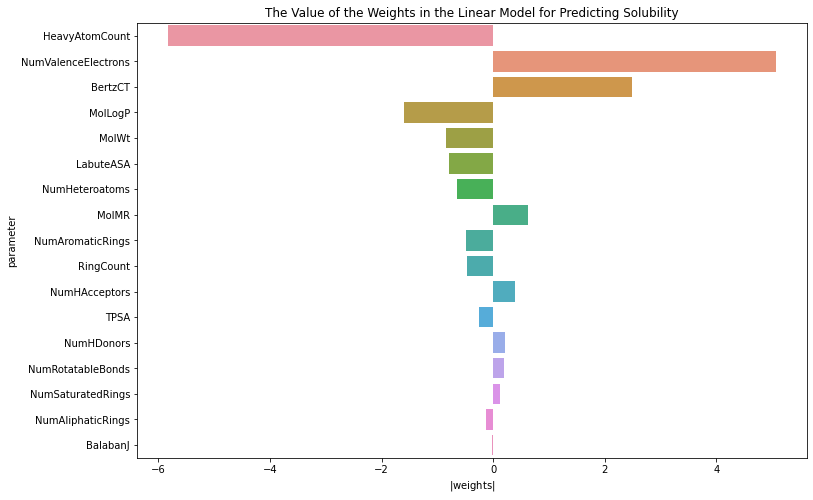

In [20]:
df_sns = pd.DataFrame(
    [{"parameter": weight[0], "linear weight": weight[1]} for weight in weights]
)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.barplot(
    data=df_sns,
    x="linear weight",
    y="parameter",
    ax=ax
)
ax.set_title("The Value of the Weights in the Linear Model for Predicting Solubility")
ax.set_xlabel("$|$weights$|$")
plt.show()

From the figure above, we have more parameters that are negatively correlated to solubility than others. Furthermore, the absolute value of the negatively correlated parameter are tend to be larger. 

In [21]:
for i in np.arange(5):
    print(weights[i])

('HeavyAtomCount', -5.837487050036324)
('NumValenceElectrons', 5.074605669634925)
('BertzCT', 2.490288304480522)
('MolLogP', -1.6040431041054433)
('MolWt', -0.8470451809305141)


The parameters above might be the first 5 most important parameter to predict solubility of compounds. We need to pay attention on them later in the project.

In [22]:
# save model for testing
linear_regression_model = model

### Variance ($r^2$) and Parity Plot 

In [23]:
print("Variance of the linear model is {0}".format(r2_score(y_nparr, model.predict(X_nparr_normalize))))

Variance of the linear model is 0.514468654456381


Linear regression model is not a good selection to predict the solubility of given parameter because the variance is low (We expect that a good model will have at least 0.80 variance). 

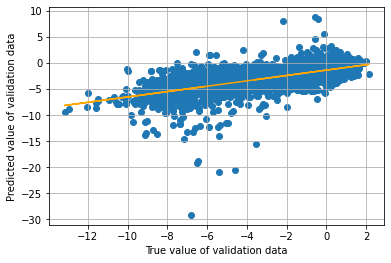

In [24]:
y_nparr_predict = model.predict(X_nparr_normalize)

plt.scatter(y_nparr, y_nparr_predict)

# line of best fit (linear regression) on the parity plot. 
coeff = np.polyfit(y_nparr, y_nparr_predict, 1)
y_nparr_predict = np.polyval(coeff, y_nparr)
plt.plot(y_nparr, y_nparr_predict, c = 'orange')  # parity_plot (true_data, predicted_data)

plt.xlabel("True value of validation data")
plt.ylabel("Predicted value of validation data")
plt.grid()
plt.show()

In [25]:
print("The slope of the fitted line is {0}.".format(np.polyfit(y_nparr, model.predict(X_nparr_normalize), 1)[0]))

The slope of the fitted line is 0.5144686544563797.


The slope in the perfectly fitted line is 1. Therefore, linear regression model is not powerful enough to predict solubility accurately. 

# Neural Networks

In [26]:
#Define a neural network model, and wrap this model in a function
def nnmodel():
    model = Sequential()
    model.add(Dense(17, input_dim=X_train_normalized.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(34, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='Adam')
    return model

In [27]:
estimator = KerasRegressor(build_fn=nnmodel) #nnmodel1 is the neural network model we defined above
history = estimator.fit(X_train_normalized, y_train, validation_split=0.3, epochs=50, batch_size=34, verbose=0)

2022-12-06 22:35:06.234006: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 22:35:06.431420: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-06 22:35:06.433409: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


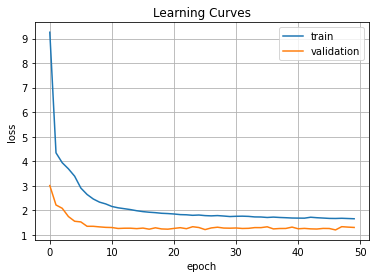

In [28]:
plt.plot(range(50),history.history['loss'])
plt.plot(range(50),history.history['val_loss'])
plt.title('Learning Curves')
plt.ylabel('loss')
plt.xlabel('epoch') 
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()
plt.show()

In [29]:
print("final MSE for train is %.2f and for validation is %.2f" % 
      (history.history['loss'][-1], history.history['val_loss'][-1]))

final MSE for train is 1.65 and for validation is 1.30


In [30]:
test_loss = estimator.model.evaluate(X_validation_normalized, y_validation)
print("test set mse is %.2f" % test_loss)

57/57 [==============================] - 0s 690us/step - loss: 1.5616
test set mse is 1.56


In [31]:
y_validation_predict = estimator.predict(X_validation_normalized)

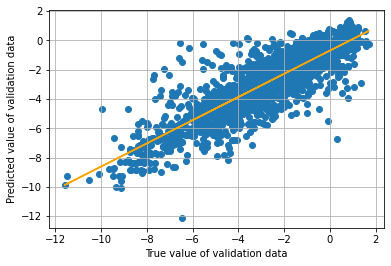

In [32]:
plt.scatter(y_validation, y_validation_predict)

# line of best fit (linear regression) on the parity plot. 
coeff = np.polyfit(y_validation, y_validation_predict, 1)
y_validation_predict_ = np.polyval(coeff, y_validation)
plt.plot(y_validation, y_validation_predict_, c = 'orange')  # parity_plot (true_data, predicted_data)

plt.xlabel("True value of validation data")
plt.ylabel("Predicted value of validation data")
plt.grid()
plt.show()

In [33]:
print("Cocariance of the neural network model is {0}".format(r2_score(y_validation, y_validation_predict)))

Variance of the neural network model is 0.7242402067715059


In [34]:
# save model for testing
neural_network_model = estimator.model

# Principal Component Analysis and Neural Network

## PCA

Principal component Analysis (PCA) is a method of unsupervised learning for feature extraction so that we can extract the features by importance. PCA is also used for dimensionality reduction to reduce high dimension dataset into lower dimension by grouping the features in the unsupervised approach. By grouping some of the original features, some information will be lost so we need to decide how many of the "new" features that we want to have in the reduced dataset. 

To do that we can plot the cumulative variance as the number of features. 

### Mathematical Perspective (SVD & Covariance) 

In [35]:
max_n_pcs = X_nparr_normalize.shape[1]

We will apply PCA on all the dimension of the data and we will plot the explained variance ratio to see what is the minimum components we can use so that we can preserve the data up to 90% with the reduced data dimension.

In [36]:
pca_17 = PCA(n_components=max_n_pcs) 
pca_17.fit(X_nparr_normalize)

PCA(n_components=17)

In [37]:
most_important_features_index = [np.abs(pca_17.components_[i]).argmax() for i in range(max_n_pcs)]
most_important_features_index

[3, 1, 11, 9, 15, 5, 7, 1, 4, 13, 13, 0, 16, 14, 2, 3, 12]

The order of features from most to least important

In [38]:
most_important_features = [X_label[i] for i in most_important_features_index]
most_important_features

['HeavyAtomCount',
 'MolLogP',
 'NumAliphaticRings',
 'NumAromaticRings',
 'BalabanJ',
 'NumHDonors',
 'NumRotatableBonds',
 'MolLogP',
 'NumHAcceptors',
 'TPSA',
 'TPSA',
 'MolWt',
 'BertzCT',
 'LabuteASA',
 'MolMR',
 'HeavyAtomCount',
 'RingCount']

Text(0, 0.5, 'Explained variance')

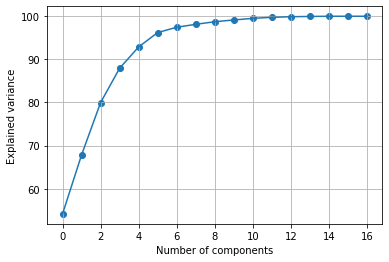

In [39]:
plt.grid()
plt.scatter(range(0,17),np.cumsum(pca_17.explained_variance_ratio_ * 100))
plt.plot(range(0,17),np.cumsum(pca_17.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

We will use 5 components of PCA since it will give us at least 90% attributes of the original dataset. 

In [40]:
pca = PCA(n_components=5) 
pca.fit(X_nparr_normalize)

PCA(n_components=5)

In [41]:
reduced_x_nparr_normal = pca.transform(X_nparr_normalize)

In [42]:
reduced_x_train_normal = pca.transform(X_train_normalized)

In [43]:
reduced_x_train_normal.shape

(7259, 5)

In [44]:
reduced_x_validation_normal = pca.transform(X_validation_normalized)

In [45]:
# reduced_x_test = pca.transform(X_test_normalized)

## NN



In [46]:
#Define a neural network model, and wrap this model in a function
def nn_PCA_model():
    model = Sequential()
    model.add(Dense(16, input_dim=reduced_x_nparr_normal.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(7, kernel_initializer='normal', activation='relu'))
    #model.add(Dense(8, kernel_initializer='normal', activation='relu'))
    model.add(Dense(4,kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [47]:
estimator = KerasRegressor(build_fn=nn_PCA_model) #nnmodel1 is the neural network model we defined above
history = estimator.fit(reduced_x_nparr_normal, y_nparr, validation_split=0.2, epochs=100, batch_size=32, verbose=0)

In [48]:
estimator.model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                96        
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 119       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 32        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 252
Trainable params: 252
Non-trainable params: 0
_________________________________________________________________


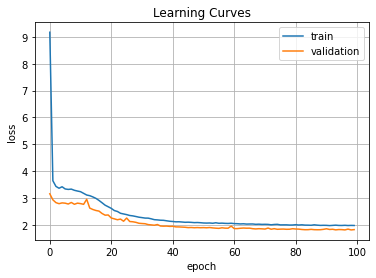

In [49]:
plt.plot(range(100),history.history['loss'])
plt.plot(range(100),history.history['val_loss'])
plt.title('Learning Curves')
plt.ylabel('loss')
plt.xlabel('epoch') 
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()
plt.show()

In [50]:
print("final MSE for train is %.2f and for validation is %.2f" % 
      (history.history['loss'][-1], history.history['val_loss'][-1]))

final MSE for train is 1.98 and for validation is 1.83


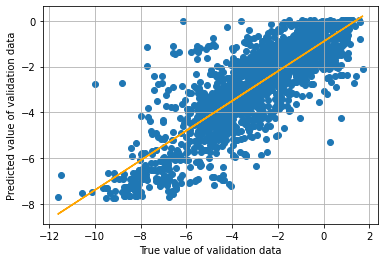

In [51]:
y_validation_predict3 = estimator.predict(reduced_x_validation_normal)
plt.scatter(y_validation, y_validation_predict3)

# line of best fit (linear regression) on the parity plot. 
coeff = np.polyfit(y_validation, y_validation_predict3, 1)
y_validation_predict3_ = np.polyval(coeff, y_validation)
plt.plot(y_validation, y_validation_predict3_, c = 'orange')  # parity_plot (true_data, predicted_data)

plt.xlabel("True value of validation data")
plt.ylabel("Predicted value of validation data")
plt.grid()
plt.show()

In [52]:
print("Variance of the PCA+NN model is {0}".format(r2_score(y_validation, y_validation_predict3)))

Variance of the PCA+NN model is 0.677454818760012


### Hyperparameter Tuning NN

In [53]:
def regression_nn_builder(hp):
    
    '''
    This is a builder function to define and compile a neural network
    
    Parameters:
    '''
    a = np.random.randint(5,15,size=1)
    b = np.random.randint(1,10,size=1)
    model = Sequential()
    model.add(Dense(units=hp.Int("units_0", min_value=1, max_value=20, step=1), 
                    input_dim=reduced_x_nparr_normal.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(units=hp.Int("units_1", min_value=1, max_value=20, step=1), kernel_initializer='normal', activation='relu'))
    model.add(Dense(units=hp.Int("units_2", min_value=1, max_value=20, step=1),kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    hp_learning_rate = hp.Choice('learning_rate', values=[5e-3,3e-3, 1e-3, 5e-4,1e-4])
        
    model.compile(loss='mean_squared_error', 
                  optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),metrics=[keras.metrics.MeanSquaredError()])
    return model

In [54]:
# set the build function to be binary_nn_builder
# set the default value of batch_size to be 32

tuner = kt.RandomSearch(
    hypermodel=regression_nn_builder,
    objective=kt.Objective("val_mean_squared_error", direction="min"),
    max_trials=40,
    executions_per_trial=3,
    overwrite=True,
    directory="tuning_hyperparameter1",
    project_name="Trial2",
)

In [55]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 20, 'step': 1, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 20, 'step': 1, 'sampling': None}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 20, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.005, 'conditions': [], 'values': [0.005, 0.003, 0.001, 0.0005, 0.0001], 'ordered': True}


In [56]:
tuner.search(reduced_x_train_normal, y_train, epochs=100, validation_data=(reduced_x_validation_normal, y_validation))

Trial 40 Complete [00h 01m 42s]
val_mean_squared_error: 2.3510896364847818

Best val_mean_squared_error So Far: 1.6584873994191487
Total elapsed time: 01h 04m 27s
INFO:tensorflow:Oracle triggered exit


In [57]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=reduced_x_nparr_normal.shape[1])
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 19)                114       
_________________________________________________________________
dense_1 (Dense)              (None, 19)                380       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                200       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________


In [58]:
best_model.evaluate(reduced_x_validation_normal, y_validation)

57/57 [==============================] - 0s 790us/step - loss: 1.9522 - mean_squared_error: 1.9522


[1.6113519668579102, 1.6113519668579102]

In [59]:
mean_squared_error(y_validation, best_model.predict(reduced_x_validation_normal))

1.6113520770909688

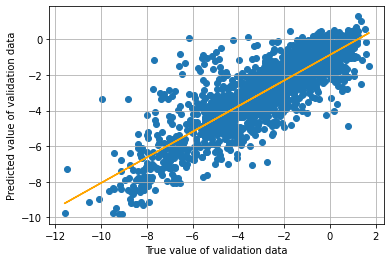

In [60]:
y_validation_predict3 = best_model.predict(reduced_x_validation_normal)
plt.scatter(y_validation, y_validation_predict3)

# line of best fit (linear regression) on the parity plot. 
coeff = np.polyfit(y_validation, y_validation_predict3, 1)
y_validation_predict3_ = np.polyval(coeff, y_validation)
plt.plot(y_validation, y_validation_predict3_, c = 'orange')  # parity_plot (true_data, predicted_data)

plt.xlabel("True value of validation data")
plt.ylabel("Predicted value of validation data")
plt.grid()

In [61]:
print("Variance of the PCA+NN model (after fine tuning) is {0}".format(r2_score(y_validation, y_validation_predict3)))

Variance of the PCA+NN model (after fine tuning) is 0.7154630444673675


In [62]:
# save model for testing
PCA_NN_model = {}
PCA_NN_model["PCA"] = pca
PCA_NN_model["nn"] = best_model

# K-Mean Cluster and Neural Network

K-mean Clustering (KMC) is an unsupervised machine-learning technique that groups similar data. Compared to PCA, which reduces the dimension of the data, grouping by K-mean Clustering reduces the mean variance of the dataset. Also, the neural network's complexity depends on the variance of datasets. In other words, if the dataset is simple, we can dramatically reduce the complexity of neural networks, resulting in models with fewer hidden layers and fewer perceptron. 

Thus, we hypothesize that running a neural network on each group would return better results because the variance of each group is significantly smaller than that of the entire dataset. 


## KMC 

### Finding Optimal Groups 

We use Elbow Mehod to find the optimal group for this dataset. 

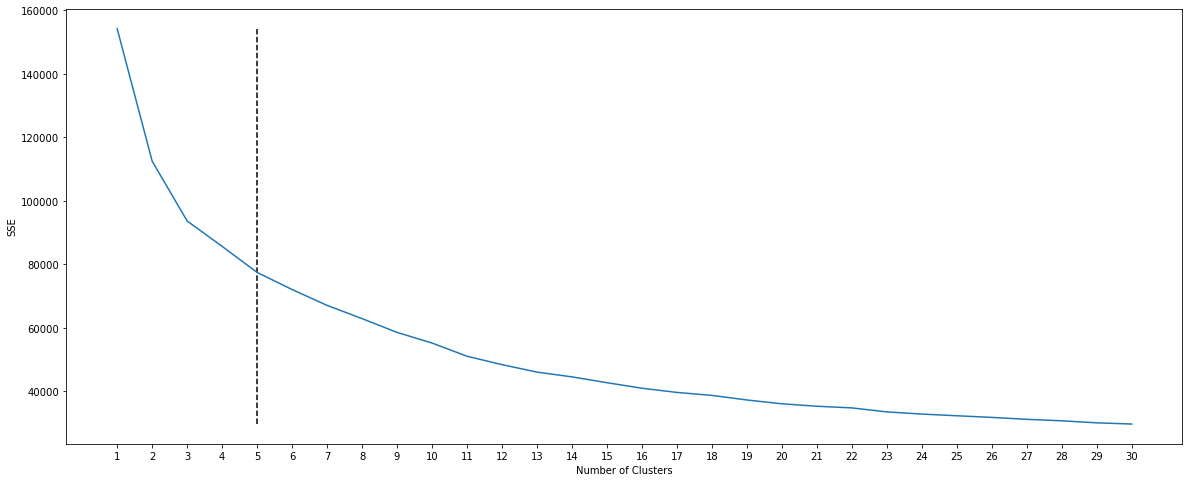

In [159]:
sse = []
x_plot = np.arange(30) + 1
for k in x_plot:
    KMC_Model = KMeans(
        n_clusters=k,
        n_init=10,
        init='k-means++',
        max_iter=300,
    ).fit(
        X_nparr_normalize
    )
    sse.append(KMC_Model.inertia_)

plt.figure(figsize=(20,8))
plt.plot(x_plot, sse)
plt.vlines(5, np.min(sse), np.max(sse), colors="k", linestyle="--")
plt.xticks(x_plot)
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

At $k=5$, the sum of the squared error is small while the number of groups is not large. 

### Calculation

In [64]:
# fit input by K-Mean clustering
num_clusters = 5
KMC_Model = KMeans(
    n_clusters=num_clusters,
    n_init=10,
    init='k-means++',
    max_iter=300,
).fit(
    X_nparr_normalize
)

K-mean cluster have very unpredictable output everytime, which makes the interpretation invalid each time we restart the script. Therefore, we fix the centroids and ease the discussion later. 

In [65]:
# Save KMC Model cluster centers
# data_directory.save_data(KMC_Model.cluster_centers_, "KMC_cluster_centers.pkl")

In [66]:
# Load KMC Model cluster centers
KMC_Model.cluster_centers_ = data_directory.load_data("KMC_cluster_centers.pkl")

In [67]:
# calculate distance between each sample and its respective centroid. 
dist = []
for centroid_idx in np.arange(num_clusters):
    # finding the euclidean disntance between given centroid and all inputs
    centroid = KMC_Model.cluster_centers_[centroid_idx]
    centroid_matrix = np.matmul(np.ones(X_nparr_normalize.shape[0]).reshape(1, -1).T, centroid.reshape(1, -1))
    dist.append(np.sum(np.power(centroid_matrix - X_nparr_normalize, 2), axis=1))

dist = np.array(dist)
    

The group sizes below. 

In [68]:
# The closest centroid for each sample
closest_centroid = np.argmin(dist, axis=0)

In [69]:
[np.count_nonzero(closest_centroid == i) for i in np.arange(num_clusters)]

[3087, 5034, 370, 42, 541]

Each centroid has decent amount of data, which is enough to run neural models. 

## NN

Due to the randomization nature of the K-Means Clustering Algorithm, the grouping varies every time we run the model. So, we will use a random search for each group's best hyperparameters, including the perception number in the first, second, and third hidden layers. 

### Model and Training

In [70]:
def nn_KMC_type(h0, h1, h2):
    model = Sequential()
    model.add(Dense(h0, input_dim=X_nparr_normalize.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(h1, kernel_initializer='normal', activation='relu'))
    model.add(Dense(h2, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [71]:
nn_models = []
for group_idx in np.arange(num_clusters):
    print("GROUP {0}".format(group_idx))
    
    NN_Model = KerasRegressor(build_fn=nn_KMC_type)
    
    rnd_search_cv = RandomizedSearchCV(
        estimator=NN_Model,
        param_distributions={
            "h0": np.arange(10, 30).tolist(),
            "h1": np.arange(5, 15).tolist(),
            "h2": np.arange(1, 10).tolist()
        },
        n_iter=30,
        cv=3,
        verbose=0,
        n_jobs=-1
    ).fit(
        X_nparr_normalize[closest_centroid == group_idx], 
        y_nparr[closest_centroid == group_idx],
        verbose=0,
        epochs=500
    )
    
    display(rnd_search_cv.best_params_)
    
    nn_models.append(rnd_search_cv.best_estimator_.model)

GROUP 0


2022-12-06 23:41:22.026068: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 23:41:22.026086: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 23:41:22.026060: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable th

33/33 [==============================] - 0s 1ms/step - loss: 1.7391


{'h2': 7, 'h1': 5, 'h0': 11}

GROUP 1
53/53 [==============================] - 0s 739us/step - loss: 0.9869


{'h2': 8, 'h1': 13, 'h0': 18}

GROUP 2
4/4 [==============================] - 0s 955us/step - loss: 4.2321


{'h2': 8, 'h1': 10, 'h0': 10}

GROUP 3
1/1 [==============================] - 0s 74ms/step - loss: 7.3082


1/1 [==============================] - 0s 158ms/step - loss: 0.6605


1/1 [==============================] - 0s 81ms/step - loss: 30.3166


1/1 [==============================] - 0s 118ms/step - loss: 32.0695


1/1 [==============================] - 0s 75ms/step - loss: 0.5239


1/1 [==============================] - 0s 160ms/step - loss: 0.6407


1/1 [==============================] - 0s 75ms/step - loss: 33.7052


1/1 [==============================] - 0s 117ms/step - loss: 7.2354


1/1 [==============================] - 0s 75ms/step - loss: 31.9906


1/1 [==============================] - 0s 127ms/step - loss: 26.2792


1/1 [==============================] - 0s 100ms/step - loss: 0.6429


1/1 [==============================] - 0s 147ms/step - loss: 0.7470


1/1 [==============================] - 0s 80ms/step - loss: 30.0011


1/1 [==============================] - 0s 114ms/step - loss: 7.6408


1/1 [==============================] - 0s 72ms/step - loss: 0.6921


1/1 [==============================] - 0s 164ms/step - loss: 7.6100


1/1 [==============================] - 0s 83ms/step - loss: 7.5530


1/1 [==============================] - 0s 86ms/step - loss: 30.9710


1/1 [==============================] - 0s 117ms/step - loss: 13.2767


1/1 [==============================] - 0s 132ms/step - loss: 0.9122


1/1 [==============================] - 0s 90ms/step - loss: 0.3852


1/1 [==============================] - 0s 109ms/step - loss: 6.9059


1/1 [==============================] - 0s 102ms/step - loss: 0.3852


1/1 [==============================] - 0s 90ms/step - loss: 7.2187


1/1 [==============================] - 0s 157ms/step - loss: 0.7549


1/1 [==============================] - 0s 109ms/step - loss: 7.5165


1/1 [==============================] - 0s 82ms/step - loss: 13.2767


1/1 [==============================] - 0s 132ms/step - loss: 0.3852


1/1 [==============================] - 0s 103ms/step - loss: 31.3731


1/1 [==============================] - 0s 119ms/step - loss: 0.3852


1/1 [==============================] - 0s 121ms/step - loss: 13.2767


1/1 [==============================] - 0s 110ms/step - loss: 0.3852


1/1 [==============================] - 0s 108ms/step - loss: 19.2607


1/1 [==============================] - 0s 130ms/step - loss: 0.7879


1/1 [==============================] - 0s 96ms/step - loss: 32.2269


1/1 [==============================] - 0s 156ms/step - loss: 7.4485


1/1 [==============================] - 0s 106ms/step - loss: 31.3766


1/1 [==============================] - 0s 115ms/step - loss: 0.7336


1/1 [==============================] - 0s 115ms/step - loss: 7.3029


1/1 [==============================] - 0s 116ms/step - loss: 31.5006


1/1 [==============================] - 0s 92ms/step - loss: 0.6982


1/1 [==============================] - 0s 87ms/step - loss: 7.4343


1/1 [==============================] - 0s 147ms/step - loss: 7.1071


1/1 [==============================] - 0s 84ms/step - loss: 30.9044


1/1 [==============================] - 0s 170ms/step - loss: 0.6432


1/1 [==============================] - 0s 124ms/step - loss: 30.9887


1/1 [==============================] - 0s 134ms/step - loss: 7.1975


1/1 [==============================] - 0s 157ms/step - loss: 1.3551


1/1 [==============================] - 0s 179ms/step - loss: 7.2602


1/1 [==============================] - 0s 126ms/step - loss: 30.2591


1/1 [==============================] - 0s 144ms/step - loss: 0.7276


1/1 [==============================] - 0s 157ms/step - loss: 7.3407


1/1 [==============================] - 0s 183ms/step - loss: 31.8804


1/1 [==============================] - 0s 159ms/step - loss: 0.6912


1/1 [==============================] - 0s 113ms/step - loss: 7.6719


1/1 [==============================] - 0s 123ms/step - loss: 30.7716


1/1 [==============================] - 0s 86ms/step - loss: 0.5984


1/1 [==============================] - 0s 76ms/step - loss: 7.4214


{'h2': 2, 'h1': 8, 'h0': 11}

GROUP 4


6/6 [==============================] - 0s 946us/step - loss: 0.8828


6/6 [==============================] - 0s 996us/step - loss: 2.2985


6/6 [==============================] - 0s 843us/step - loss: 3.1677


{'h2': 8, 'h1': 13, 'h0': 15}

### Validation

In [72]:
dist = []
for centroid_idx in np.arange(num_clusters):
    # finding the euclidean disntance between given centroid and all inputs
    centroid = KMC_Model.cluster_centers_[centroid_idx]
    centroid_matrix = np.matmul(np.ones(X_validation_normalized.shape[0]).reshape(1, -1).T, centroid.reshape(1, -1))
    dist.append(np.sum(np.power(centroid_matrix - X_validation_normalized, 2), axis=1))

dist = np.array(dist)

In [73]:
closest_centroid = np.argmin(dist, axis=0)

In [74]:
centroid_sizes = [np.count_nonzero(closest_centroid == i) for i in np.arange(num_clusters)]
print("The group sizes are: {0}".format(centroid_sizes))

The group sizes are: [642, 991, 66, 8, 108]


In [75]:
y_validation_ = np.ones(y_validation.shape)
for group_idx in np.arange(num_clusters):
    y_validation_group = nn_models[group_idx].predict(X_validation_normalized[closest_centroid == group_idx])
    y_validation_[closest_centroid == group_idx] = y_validation_group.reshape(-1)

    print("GROUP {0}: MSE = {1}".format(group_idx, mean_squared_error(y_validation[closest_centroid == group_idx], y_validation_group)))

print("\nOverall: MSE = {0}".format(mean_squared_error(y_validation, y_validation_)))

GROUP 0: MSE = 1.4216832583137398
GROUP 1: MSE = 0.803583035353485
GROUP 2: MSE = 1.9371153616280339
GROUP 3: MSE = 0.3722268874952725
GROUP 4: MSE = 0.8843280000877015

Overall: MSE = 1.0663395552890407


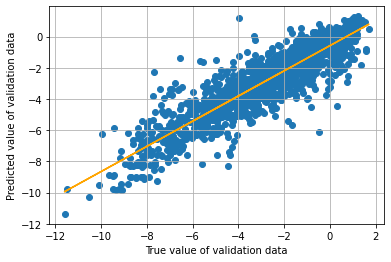

In [76]:
y_validation_predict = y_validation_
plt.scatter(y_validation, y_validation_predict)

# line of best fit (linear regression) on the parity plot. 
coeff = np.polyfit(y_validation, y_validation_predict, 1)
y_validation_predict_ = np.polyval(coeff, y_validation)
plt.plot(y_validation, y_validation_predict_, c = 'orange')  # parity_plot (true_data, predicted_data)

plt.xlabel("True value of validation data")
plt.ylabel("Predicted value of validation data")
plt.grid()
plt.show()

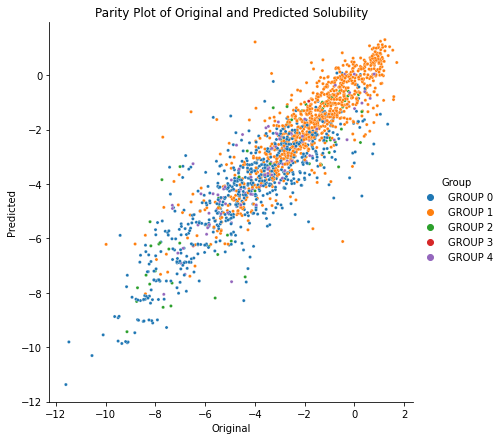

In [77]:
df_sns = pd.DataFrame(
    {"Original": y_validation, "Predicted": y_validation_, "Group": ["GROUP {0}".format(i) for i in closest_centroid]}
)

g = sns.relplot(
    data=df_sns,
    x="Original",
    y="Predicted",
    hue="Group",
    kind="scatter",
    hue_order=["GROUP {0}".format(i) for i in np.arange(num_clusters)],
    s=10,
    aspect=1,
    height=6
)
g.ax.set_title("Parity Plot of Original and Predicted Solubility")
plt.show()

In the plot above, we can distinguish each group, which is a good indicator that models aggregate similar samples and neural networks are able to predict their solubility. 

In [78]:
print("Variance of the KMC+NN model is {0}".format(r2_score(y_validation, y_validation_)))

Variance of the KMC+NN model is 0.8117028457407477


However, the variance and mean-square-value of the validation data shows that KMC+NN does not provide clear advantage over regular NN model. 

In [79]:
# save model for testing
KMC_NN_model = {}
KMC_NN_model["KMC"] = KMC_Model
KMC_NN_model["nn"] = nn_models

# KMC+NN model predicting precedure 
def KMC_NN_predict(KMC_NN_model, X_test):
    dist = []
    for centroid_idx in np.arange(num_clusters):
        centroid = KMC_NN_model["KMC"].cluster_centers_[centroid_idx]
        centroid_matrix = np.matmul(np.ones(X_test.shape[0]).reshape(1, -1).T, centroid.reshape(1, -1))
        dist.append(np.sum(np.power(centroid_matrix - X_test, 2), axis=1))
    closest_centroid = np.argmin(np.array(dist), axis=0)
    y_test_ = np.ones(X_test.shape[0])
    for group_idx in np.arange(num_clusters):
        y_test_group = KMC_NN_model["nn"][group_idx].predict(X_test[closest_centroid == group_idx])
        y_test_[closest_centroid == group_idx] = y_test_group.reshape(-1)
    return y_test_

# Testing and Benchmark

In the previous sections, we have developed the following algorithms to predict the model solubilities. 
- Linear Regression
- Neural Network
- Neural Network on Reduced-Dimension Data by Principal Component Analysis (PCA+NN)
- Neural Network on Grouped Data by K-Mean Clusering (KMC+NN)

Now, we are run each model on the testing dataset. The test criteria are following:
- Mean Square Error (MSE)
- Variance ("r2 score")
- Parity Plot

Testing dataset has not expose to any of the model yet, therefore, it serves as an objective benchmark for each model's performace. 

In [80]:
# load check point

# only import testing data
_, _, data_test = data_directory.load_data("Solubility Data Splitted.pkl")

X_test, y_test, ID_test = data_test

# normalize testing data
X_test_normalized = X_scaler.transform(X_test)

In [81]:
def print_testing_metrics(a_true, a_fit):
    print("Covariance: {0}".format(r2_score(a_true, a_fit)))
    print("       MSE: {0}".format(mean_squared_error(a_true, a_fit)))
    plt.scatter(a_true, a_fit)

    # line of best fit (linear regression) on the parity plot. 
    a_fit_ = np.polyval(np.polyfit(a_true, a_fit, 1), a_true)
    plt.plot(a_true, a_fit_, c = 'orange')

    plt.xlabel("True value of testing data")
    plt.ylabel("Predicted value of testing data")
    plt.grid()
    plt.show()

## Linear Regression

Covariance: 0.5071677649499687
       MSE: 2.6412435958194704


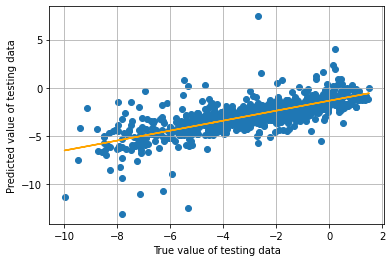

In [82]:
print_testing_metrics(y_test, linear_regression_model.predict(X_test_normalized))

## Neural Network

Covariance: 0.6963961390293855
       MSE: 1.627108976289455


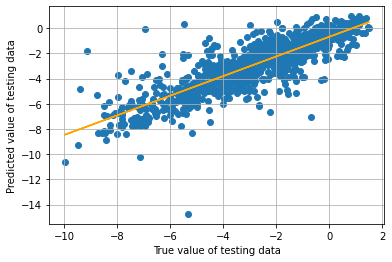

In [83]:
print_testing_metrics(y_test, neural_network_model.predict(X_test_normalized))

## PCA+NN

Covariance: 0.6818964047937786
       MSE: 1.7048176314203298


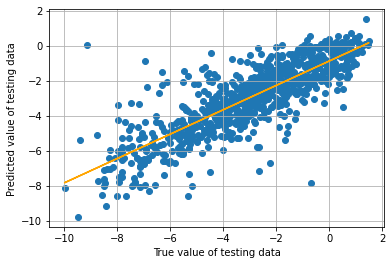

In [84]:
print_testing_metrics(y_test, PCA_NN_model["nn"].predict(PCA_NN_model["PCA"].transform(X_test_normalized)))

## KMC+NN

Covariance: 0.7538701265934011
       MSE: 1.319087725276413


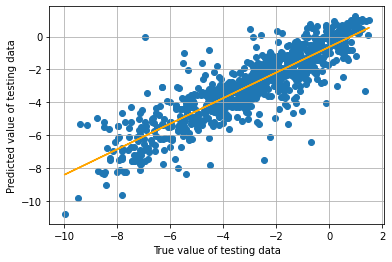

In [86]:
print_testing_metrics(y_test, KMC_NN_predict(KMC_NN_model, X_test_normalized))

# Discussion

## PCA Visualizations

We project the testing dataset into 2-dimensional space constructed by `pc0` and `pc1`, the first two princpal component vector of **training** and **validation** dataset. We choose training and validation dataset to fit the PCA model to make the result consistent to previous and latter section. 

In [136]:
pca2 = PCA(n_components=2)
X_test_pca2 = pca2.fit(X_nparr_normalize).transform(X_test_normalized)

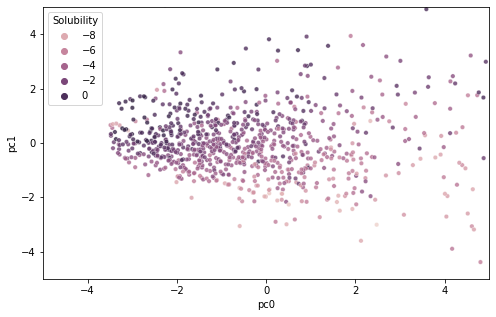

In [149]:
df_sns = pd.DataFrame(
    [
        {"pc0": pc[0], "pc1": pc[1], "Solubility": sol}
        for pc, sol in zip(X_test_pca2, y_test)
    ]
)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.scatterplot(
    data=df_sns,
    x="pc0",
    y="pc1", 
    hue="Solubility",
    alpha=0.8,
    s=20
)
ax.set_ylim(-5, 5)
ax.set_xlim(-5, 5)
plt.show()

As the graph shown above, we can see some separation of molecules with high and low solubilities. However, the dataset is complicated because it is not linearily separable nor have distinctive clusters. Therefore, we need more than 2 dimensions to have accurate predictions. 

Note: We use 5 dimensions in our entire analysis. Projecting into 2 dimensions is only for visualizations of data separation. 

## PCA and Linear Regression Weights
<font color="red">**Answering Our Hypothesis**</font>

The PCA result is almost the same as the linear regression result. In our PCA analysis, we reduce our dimension from 17 to 5 variables. Then, we pick the first two principal component vector, `PC0` and `PC1`, since these two contribute the most when predicting solubility. 

In [118]:
# get pc0 and pc2 from our previous pca analysis
pc0, pc1 = PCA_NN_model["PCA"].components_[:2]

In [119]:
# get the weights from linear regression for sorting purpose
weights = list(zip(X_label, linear_regression_model.coef_))
weights.sort(key=lambda x: np.abs(x[1]), reverse=True)

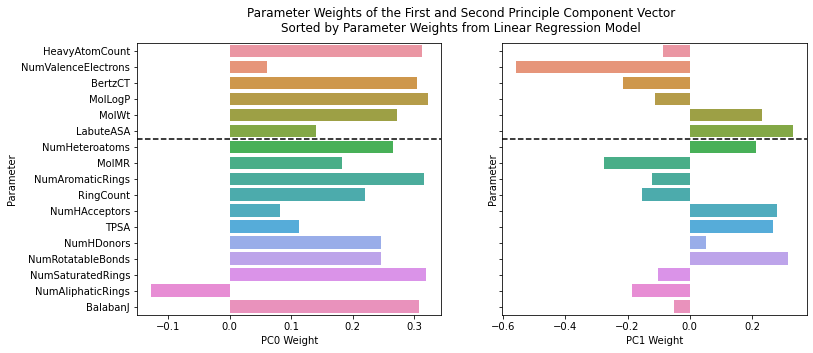

In [126]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 5))

# pc0 plot
sns.barplot(
    data=pd.DataFrame(
        {"Parameter": [weight[0] for weight in weights], "PC0 Weight": pc0}
    ),
    x="PC0 Weight",
    y="Parameter",
    ax=axes[0]
)
axes[0].axhline(5.5, c="k", linestyle="--") # reference line, first 6 features

# pc1 plot
sns.barplot(
    data=pd.DataFrame(
        {"Parameter": [weight[0] for weight in weights], "PC1 Weight": pc1}
    ),
    x="PC1 Weight",
    y="Parameter",
    ax=axes[1]
)
axes[1].axhline(5.5, c="k", linestyle="--") # reference line, first 6 features

fig.suptitle(
    "Parameter Weights of the First and Second Principle Component Vector" + 
    "\nSorted by Parameter Weights from Linear Regression Model"
)
plt.show()

As Figure shown above, `PC0` includes 5 heavy-weighted features similar to linear regression
1. `Heavy atom count`
1. `BertzCT`
1. `MolLogP`
1. `MolWt`
1. `LabuteASA` (partial)

The second variable, `PC1`, includes remaining such features
1. `Num valence electrons`
1. `LabuteASA` (partial)

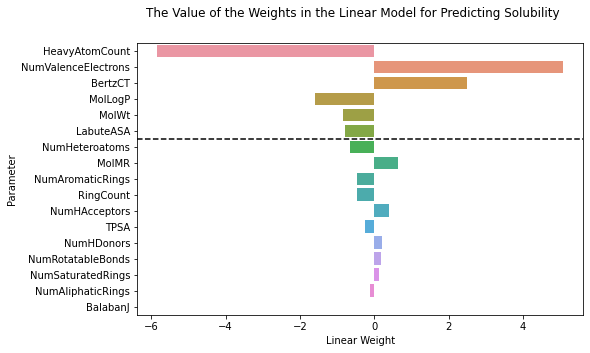

In [135]:
df_sns = pd.DataFrame(
    [{"Parameter": weight[0], "Linear Weight": weight[1]} for weight in weights]
)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.barplot(
    data=df_sns,
    x="Linear Weight",
    y="Parameter",
    ax=ax
)
ax.axhline(5.5, c="k", linestyle="--") # reference line, first 6 features
fig.suptitle("The Value of the Weights in the Linear Model for Predicting Solubility")
plt.show()

Based on our linear regression results (shown above), the value of `MolLogP` is at the fourth place, while the value of the weights of `LabuteASA` is lower than `MolLogP`. However, in the PCA results, the importance of these two features seems to be exchanged when we combine both `pc0` and `pc1`. `LabuteASA`, or Labute’s Approximate Surface Area, provides a more comprehensive characterization of molecules which is a descriptor based on the subdivision and classification of the molecular surface area according to atomic properties (such as contribution to log, molar refractivity, and partial charge). 

In addition, since it is impossible to measure $K_{ow}$ for all substances, various models are mainly based on estimation and prediction. Also, the definition of the $K_{ow}$ or P-value $P$ is $$K_{ow} = P = \frac{c_o^{S_i}}{c_w^{S_i}}$$, where $c_o^{S_i}$ is the concentration of species $i$ of a substance in the octanol-rich phase, and $c_w^{S_i}$ is that in the water-rich phase. In other words, $K_{ow}$ could be affected by the solubility of certain species in the octanol-rich phase. However, since our dataset focuses on the aqueous solution (water-rich phase), `MolLogP` is not an accurate way for our research project.

## PCA+NN Model vs Plain Neural Network

The testing results from the previous section (also below) show that the performance of the *PCA+NN* model does not match the plain Neural Network. 

In [173]:
pd.DataFrame([
    {"Model": "PCA+NN", "MSE": mean_squared_error(y_test, PCA_NN_model["nn"].predict(PCA_NN_model["PCA"].transform(X_test_normalized)))}, 
    {"Model": "NN", "MSE": mean_squared_error(y_test, neural_network_model.predict(X_test_normalized))}
])

,Model,MSE
0,PCA+NN,1.704818
1,NN,1.627109


This behavior is consistent our prediction because PCA reduces the complexity of the data. Even though simple data are easier to store, compute, and interpret by humans, they still need more degrees of freedom to describe their solubility. As for the result, we trade the prediction accuracy for a simpler and faster neural network model. 

## Neural Networks with K-Mean Clustering Result (KMC+NN)

We observed the unpredictability of the K-means clustering algorithm during model training. Training the neural network with clustered data sometimes gives us better results, and we suspect the group size of each centroid is an important factor. Thus, we tuned the centroids with validation data and fixed them for the latter analysis. (Testing dataset is not part of the tuning process, which still remains unbiased as benchmark.)

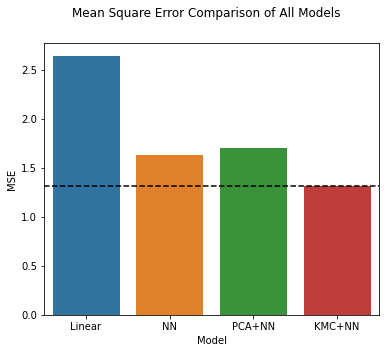

In [165]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.barplot(
    data=pd.DataFrame([
        {"Model": "Linear", "MSE": mean_squared_error(y_test, linear_regression_model.predict(X_test_normalized))},
        {"Model": "NN", "MSE": mean_squared_error(y_test, neural_network_model.predict(X_test_normalized))},
        {"Model": "PCA+NN", "MSE": mean_squared_error(y_test, PCA_NN_model["nn"].predict(PCA_NN_model["PCA"].transform(X_test_normalized)))}, 
        {"Model": "KMC+NN", "MSE": mean_squared_error(y_test, KMC_NN_predict(KMC_NN_model, X_test_normalized))}
    ]),
    x="Model", 
    y="MSE",
    ax=ax
)

ax.axhline(mean_squared_error(y_test, KMC_NN_predict(KMC_NN_model, X_test_normalized)), c="k", linestyle="--")
fig.suptitle("Mean Square Error Comparison of All Models")
plt.show()

By grouping entire dataset, the variance of each cluster is smaller than the variance of entire dataset, which is easier to train neural network model on each clusers. This behabvior is shown in the parity plot below. 

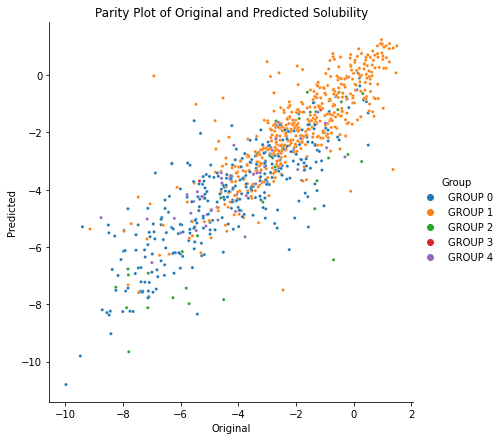

In [257]:
df_sns = pd.DataFrame({
    "Original": y_test, 
    "Predicted": KMC_NN_predict(KMC_NN_model, X_test_normalized), 
    "Group": ["GROUP {0}".format(group) for group in KMC_NN_model["KMC"].predict(X_test_normalized)]
})

g = sns.relplot(
    data=df_sns,
    x="Original",
    y="Predicted",
    hue="Group",
    kind="scatter",
    hue_order=["GROUP {0}".format(i) for i in np.arange(num_clusters)],
    s=10,
    aspect=1,
    height=6
)
g.ax.set_title("Parity Plot of Original and Predicted Solubility")
plt.show()

Each group represents a region in the parity plot, and their respective neural network model is only responsible for that small region. This is another reason why finding centroids that are representative of future input is important. 

We can plot the parity plot in a different way to emphize the solubility distribution of each group. 

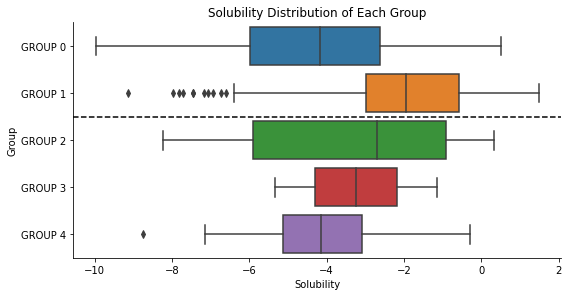

In [258]:
g = sns.catplot(
    data=df_sns,
    x="Original",
    y="Group",
    order=["GROUP {0}".format(i) for i in np.arange(num_clusters)],
    kind="box",
    aspect=2,
    height=4
)
g.ax.set_xlabel("Solubility")
g.ax.axhline(1.5, c="k", linestyle="--")
g.ax.set_title("Solubility Distribution of Each Group")
plt.show()

As for the interpretation of K-Mean Clustering itself, it is difficult to analyze the behavior due to its nature as unsupervized learning algorithm. Still, we can examine the clusters `GROUP 0` and `GROUP 1`, the largest two groups in the parity plot. Additionally, the distribution of these two groups has minimal overlap in the solubility distribution plot above. Minimal overlap is another indicator for separable data. 

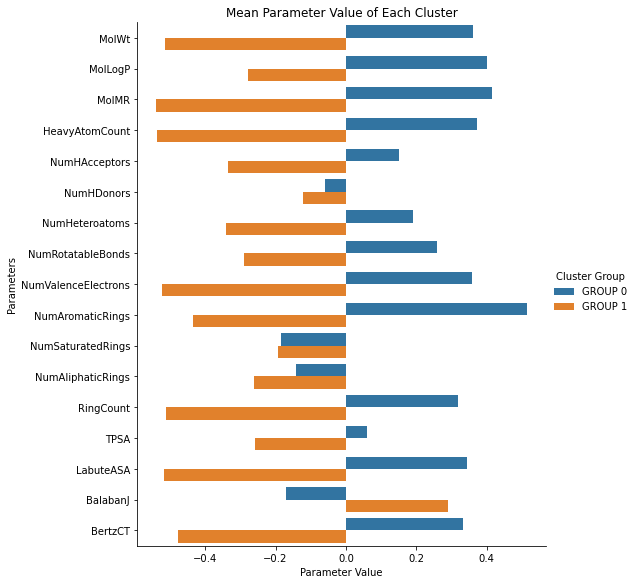

In [259]:
# merge cluster center and label for ploting purpose
df_cluster = pd.DataFrame(KMC_NN_model["KMC"].cluster_centers_, columns=X_label)
df_cluster["Cluster Group"] = ["GROUP {0}".format(i) for i in np.arange(num_clusters)]
df_cluster=df_cluster.melt(id_vars="Cluster Group", var_name="Parameters", value_name="Parameter Value")

g = sns.catplot(
    data=df_cluster[(df_cluster["Cluster Group"] == "GROUP 0") | (df_cluster["Cluster Group"] == "GROUP 1")],
    hue="Cluster Group",
    x="Parameter Value",
    y="Parameters",
    kind="bar",
    aspect=1,
    height=8
)
g.ax.set_title("Mean Parameter Value of Each Cluster")
plt.show()

`GROUP 0` mostly contains parameters with positive values (after being normalized by the training dataset), which correspond to the slightly more negative region of solubility; the opposite happens to `GROUP 1`. 

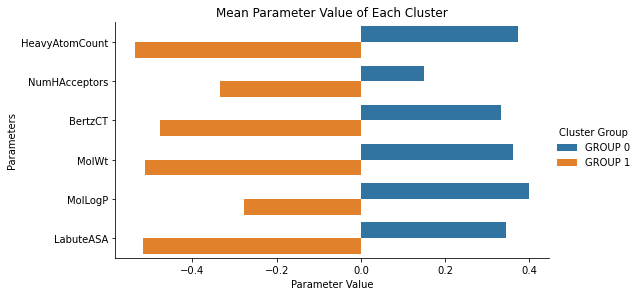

In [260]:
linear_important_label = ['HeavyAtomCount', 'NumHAcceptors', 'BertzCT', 'MolWt', 'MolLogP', 'LabuteASA']

df_cluster_2 = pd.DataFrame(KMC_NN_model["KMC"].cluster_centers_, columns=X_label)
df_cluster_2["Cluster Group"] = ["GROUP {0}".format(i) for i in np.arange(num_clusters)]

# filter linear important labels
df_cluster_2 = df_cluster_2[["Cluster Group"] + linear_important_label]
df_cluster_2 = df_cluster_2.melt(id_vars="Cluster Group", var_name="Parameters", value_name="Parameter Value")

# only look at group 0 and 1
df_cluster_2 = df_cluster_2[
    (df_cluster_2["Cluster Group"] == "GROUP 0") | 
    (df_cluster_2["Cluster Group"] == "GROUP 1")
]

g = sns.catplot(
    data=df_cluster_2,
    hue="Cluster Group",
    x="Parameter Value",
    y="Parameters",
    kind="bar",
    aspect=2,
    height=4
)
g.ax.set_title("Mean Parameter Value of Each Cluster")
plt.show()

When we only look at those parameters which are important to linear regression and PCA, they have opposite sign and large magnitude in `GROUP 0` and `GROUP 1`. In other words, separating the dataset into groups by those 6 parameter will significantly improve the prediction. This result is consistent with both linear regression and PCA. 

# Acknowledgement

Thank you to Instructors and TAs for their instruction during the quarter and guide us through the project.

Resource:
* AqSolDB: A curated aqueous solubility dataset https://www.kaggle.com/datasets/sorkun/aqsoldb-a-curated-aqueous-solubility-datase
* Python: Feature/Variable importance after a PCA analysis https://pyquestions.com/feature-variable-importance-after-a-pca-analysis 
* Keras API reference: https://keras.io/api/
* Derivation and Applications of Molecular Descriptors Based on Approximate Surface Area: https://link.springer.com/protocol/10.1385/1-59259-802-1:261